# Cleaning anomalies in time series per region slug



## Load  libraries

In [56]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

In [25]:
#import pandas as pd  
#import datetime 
#dates = pd.Series(['2010-11-01','2010-11-02','2010-11-03',
#               '2010-12-24', '2010-12-25', '2010-12-26', 
#               '2010-12-27', '2010-12-28', '2010-12-29', 
#               '2010-12-30', '2011-01-01', '2011-01-02'])

#### Run single

In [57]:
from src.runners.clean import _run_single 

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
2021-05-07 12:45:37.709 | INFO     | src.runners.clean:_run_single:819 - ... here we go torreon...

2021-05-07 12:45:37.712 | DEBUG    | src.runners.clean:_reading_data:680 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('torreon')
        
2021-05-07 12:45:39.417 | DEBUG    | src.runners.clean:_c_param:356 - C max: 0.7849571168548051
2021-05-07 12:45:39.421 | DEBUG    | src.runners.clean:_run_step:754 - ... step start ...
2021-05-07 12:45:39.421 | INFO     | src.runners.clean:_run_step:755 - Target variable: observed 

2021-05-07 12:45:39.422 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding ou

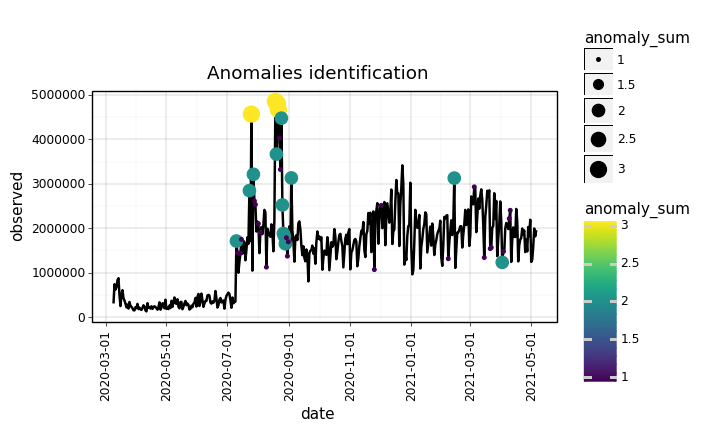

2021-05-07 12:45:39.982 | DEBUG    | src.runners.clean:_impute_anomalies:303 - 
... imputing outliers ...


<ggplot: (8729442315377)>


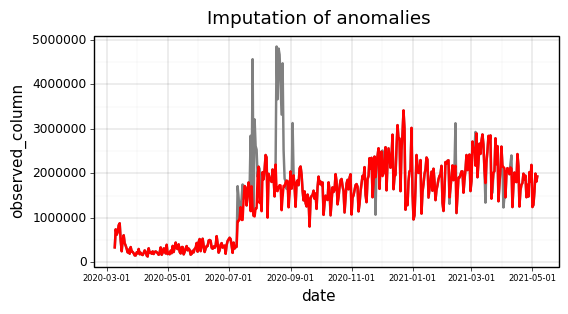

2021-05-07 12:45:40.372 | INFO     | src.runners.clean:_run_step:774 - Output variable S1_shift
2021-05-07 12:45:40.373 | DEBUG    | src.runners.clean:_shift_level:539 - 

2021-05-07 12:45:40.373 | DEBUG    | src.runners.clean:_shift_level:540 - ... shifting levels for Loess ...
2021-05-07 12:45:40.375 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-07 12:45:40.381 | DEBUG    | src.runners.clean:_run_shift_grid:406 - ... shift level running grid  ...



<ggplot: (8729434731141)>


2021-05-07 12:45:41.113 | DEBUG    | src.runners.clean:_run_shift_grid:426 - Total combinations: 25

2021-05-07 12:45:41.345 | DEBUG    | src.runners.clean:_initial_shift_date:481 - Shift found at 2020-07-08 00:00:00
2021-05-07 12:45:41.348 | DEBUG    | src.runners.clean:_shift_ts:515 - 

2021-05-07 12:45:41.348 | DEBUG    | src.runners.clean:_shift_ts:516 - Center point: -512481.09094569966
../src/runners/clean.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:488: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/s

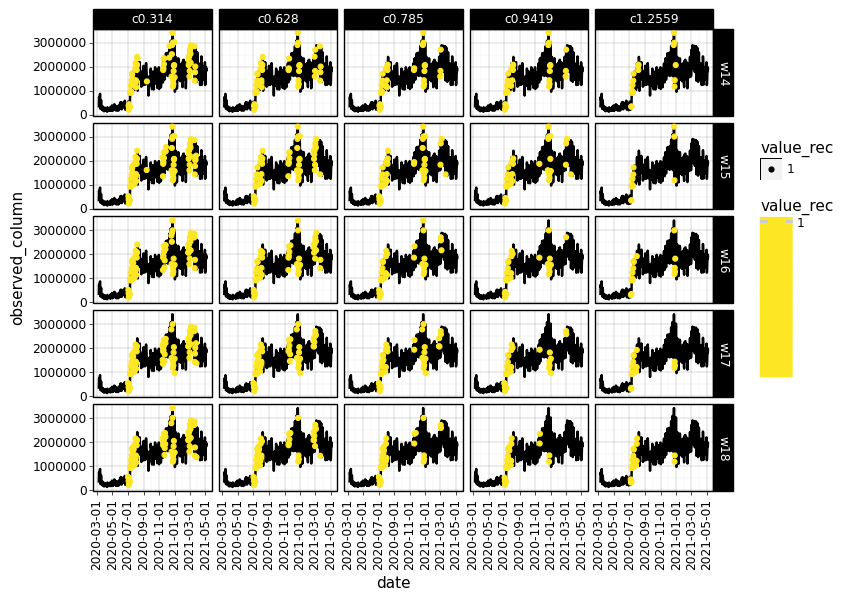

<ggplot: (8729432128741)>


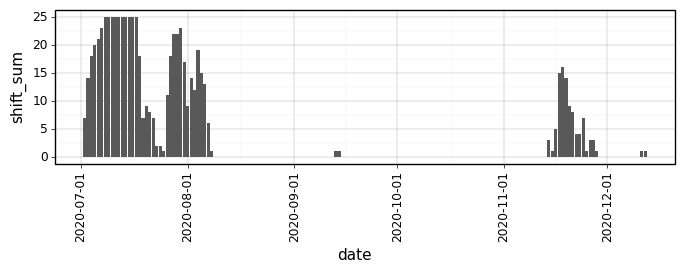

<ggplot: (8729431783137)>


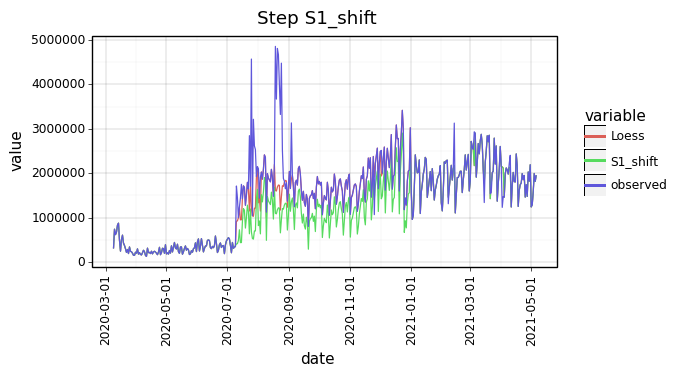

2021-05-07 12:45:55.227 | DEBUG    | src.runners.clean:_run_step:803 - ... step done ...
2021-05-07 12:45:55.230 | DEBUG    | src.runners.clean:_run_step:754 - ... step start ...
2021-05-07 12:45:55.231 | INFO     | src.runners.clean:_run_step:755 - Target variable: S1_shift 

2021-05-07 12:45:55.232 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-07 12:45:55.233 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-05-07 12:45:55.238 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

<ggplot: (8729441478225)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 406 rows containing missing values.


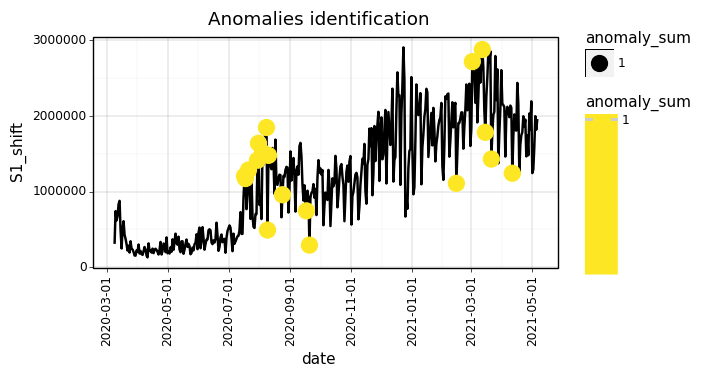

2021-05-07 12:45:55.729 | DEBUG    | src.runners.clean:_impute_anomalies:303 - 
... imputing outliers ...


<ggplot: (8729433677177)>


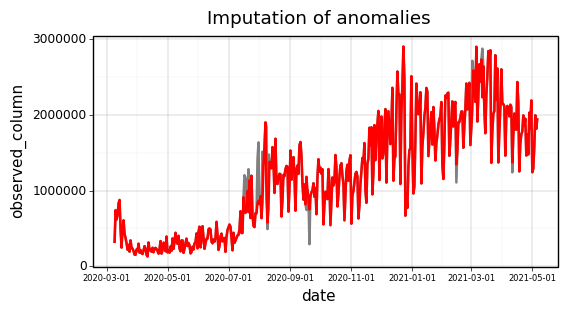

2021-05-07 12:45:56.103 | INFO     | src.runners.clean:_run_step:774 - Output variable S2_shift
2021-05-07 12:45:56.104 | DEBUG    | src.runners.clean:_shift_level:539 - 

2021-05-07 12:45:56.105 | DEBUG    | src.runners.clean:_shift_level:540 - ... shifting levels for Loess ...
2021-05-07 12:45:56.107 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-07 12:45:56.112 | DEBUG    | src.runners.clean:_run_shift_grid:406 - ... shift level running grid  ...



<ggplot: (8729441481249)>


2021-05-07 12:45:56.659 | DEBUG    | src.runners.clean:_run_shift_grid:426 - Total combinations: 25

2021-05-07 12:45:56.888 | DEBUG    | src.runners.clean:_initial_shift_date:481 - Shift found at 2020-08-04 00:00:00
2021-05-07 12:45:56.891 | DEBUG    | src.runners.clean:_shift_ts:515 - 

2021-05-07 12:45:56.892 | DEBUG    | src.runners.clean:_shift_ts:516 - Center point: -403088.32609296276
../src/runners/clean.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:488: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/s

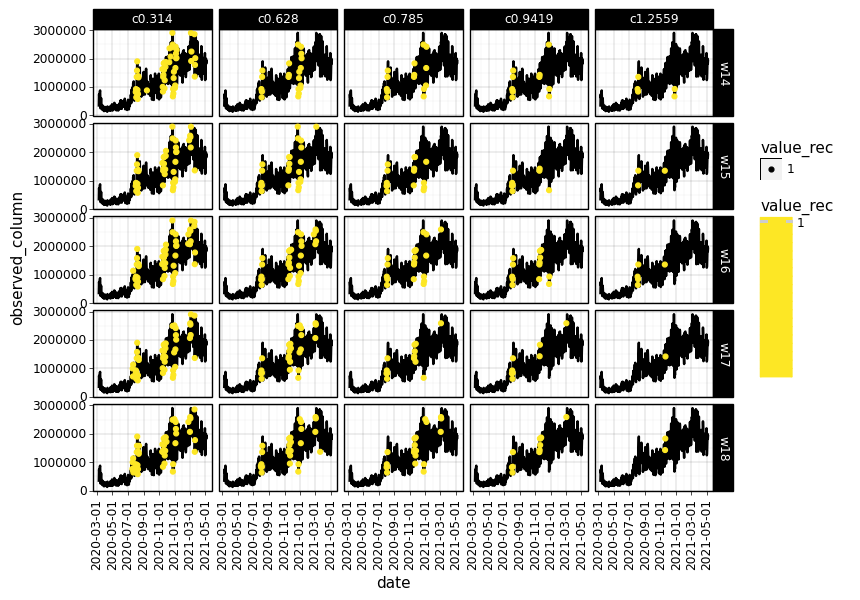

<ggplot: (8729432099193)>


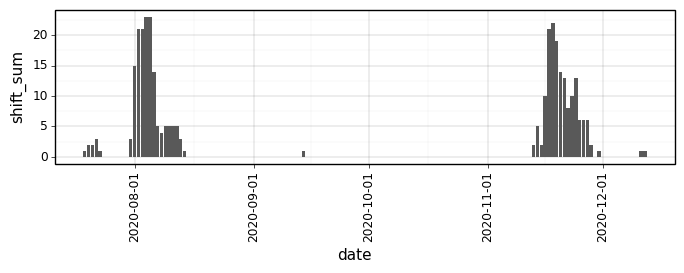

<ggplot: (8729435785181)>


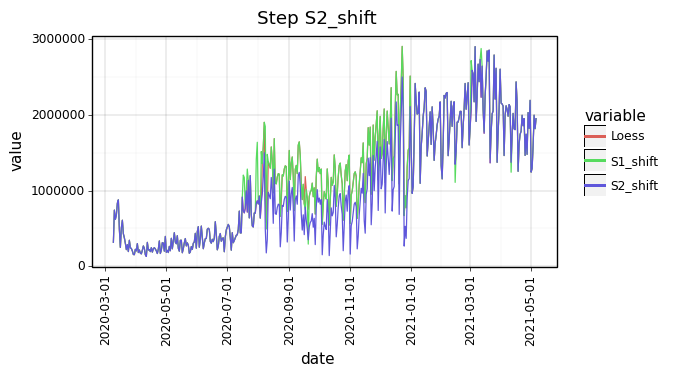

2021-05-07 12:46:11.465 | DEBUG    | src.runners.clean:_run_step:803 - ... step done ...
2021-05-07 12:46:11.645 | DEBUG    | src.runners.clean:_write_missing:687 - ... writing anomalies file ...


<ggplot: (8729441395333)>


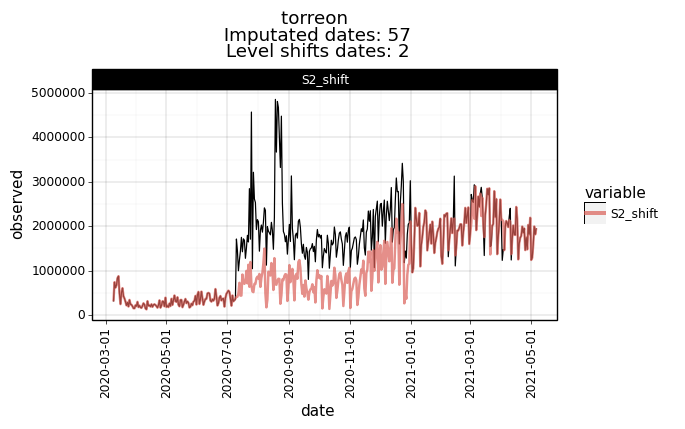

<ggplot: (8729434679749)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_torreon.pdf
2021-05-07 12:46:13.457 | INFO     | src.runners.clean:_run_single:869 - ... torreon done ...



In [76]:
daily, weekly = _run_single(region_slug='torreon', 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            c_metric = 'max', 
                            print_report = True, 
                            print_plot = True)

In [4]:
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

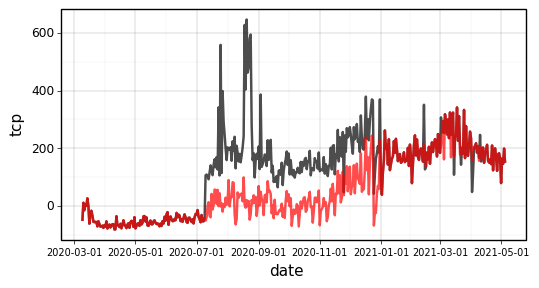

<ggplot: (8729433753585)>

In [74]:
daily.head(3)
gg = (p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line(size= 1, alpha = .7)
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red', size= 1, alpha = .7)
 + p9.theme(figure_size=(6, 3),
            axis_text_x=p9.element_text(size = 7)) )
gg 

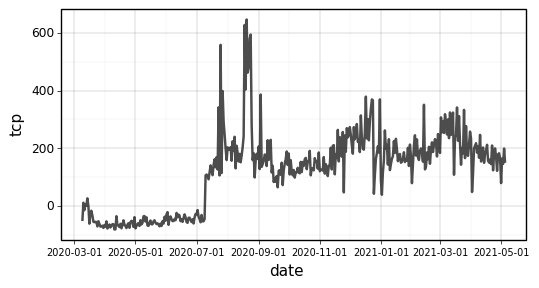

<ggplot: (8729457535781)>

In [75]:
daily.head(3)
gg = (p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line(size= 1, alpha = .7)
 + p9.theme(figure_size=(6, 3),
            axis_text_x=p9.element_text(size = 7)) )
gg 

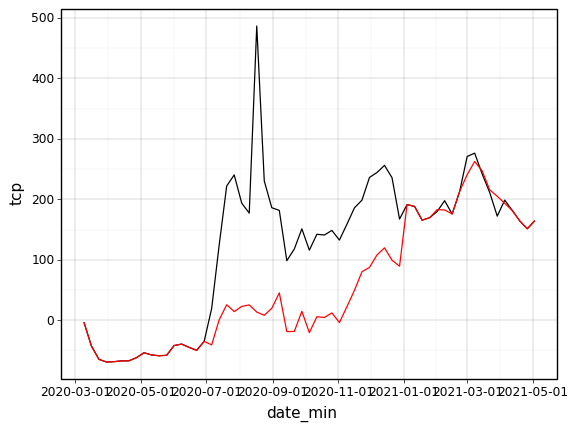

<ggplot: (8729435021177)>

In [66]:
weekly.head(3)
gg = (p9.ggplot(weekly, p9.aes(x = 'date_min', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))
gg

In [101]:
print(daily.date.min())
print(daily.date.max())
print(weekly.week.max())

2020-03-09 00:00:00
2021-04-27 00:00:00
60


#### Run by batch

In [7]:
from src.runners.clean import _run_batch 

In [8]:
_run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona", 
          c_metric = 'max')

2021-05-06 12:07:05.928 | INFO     | src.runners.clean:_run_batch:880 - TO DO regions  81
2021-05-06 12:07:05.929 | INFO     | src.runners.clean:_run_single:814 - ... here we go aguascalientes...

2021-05-06 12:07:05.930 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('aguascalientes')
        


aguascalientes


2021-05-06 12:07:08.549 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0273899198125596
2021-05-06 12:07:08.552 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:08.553 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:08.554 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:08.555 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:08.561 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

arequipa


2021-05-06 12:07:14.430 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3707797834677795
2021-05-06 12:07:14.433 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:14.434 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:14.434 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:14.436 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:14.442 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:07:16.543 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_arequipa.pdf
2021-05-06 12:07:18.174 | INFO     | src.runners.clean:_run_single:864 - ... arequipa done ...

2021-05-06 12:07:18.175 | INFO     | src.runners.clean:_run_single:814 - ... here we go barranquilla...

2021-05-06 12:07:18.176 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('barranquilla')
        


barranquilla


2021-05-06 12:07:20.654 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.76668667025904
2021-05-06 12:07:20.657 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:20.658 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:20.659 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:20.660 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:20.666 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.76668667025904
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

2021-05-06 12:07:22.769 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_barranquilla.pdf
2021-05-06 12:07:24.122 | INFO     | src.runners.clean:_run_single:864 - ... barranquilla done ...

2021-05-06 12:07:24.123 | INFO     | src.runners.clean:_run_single:814 - ... here we go belem...

2021-05-06 12:07:24.124 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('belem')
        


belem


2021-05-06 12:07:26.597 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.6751306885065211
2021-05-06 12:07:26.600 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:26.601 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:26.601 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:26.603 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:26.609 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:07:30.294 | INFO     | src.runners.clean:_run_single:814 - ... here we go belohorizonte...

2021-05-06 12:07:30.297 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('belohorizonte')
        


belohorizonte


2021-05-06 12:07:31.912 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7932268803995419
2021-05-06 12:07:31.915 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:31.916 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:31.917 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:31.918 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:31.924 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

bogota


2021-05-06 12:07:38.217 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.7885534354346917
2021-05-06 12:07:38.220 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:38.221 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:38.221 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:38.223 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:38.228 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.7885534354346917
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

brasilia


2021-05-06 12:07:44.557 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.045577611833902
2021-05-06 12:07:44.561 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:44.562 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:44.562 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:44.564 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:44.570 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

bucaramanga


2021-05-06 12:07:50.473 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6872269818077374
2021-05-06 12:07:50.476 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:50.477 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:50.478 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:50.479 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:50.485 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6872269818077374
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

2021-05-06 12:07:54.053 | INFO     | src.runners.clean:_run_single:864 - ... bucaramanga done ...

2021-05-06 12:07:54.054 | INFO     | src.runners.clean:_run_single:814 - ... here we go buenosaires...

2021-05-06 12:07:54.055 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('buenosaires')
        


buenosaires


2021-05-06 12:07:57.048 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.9098498045084976
2021-05-06 12:07:57.051 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:07:57.052 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:07:57.053 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:07:57.054 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:07:57.060 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

cali


2021-05-06 12:08:02.125 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4587580136087392
2021-05-06 12:08:02.128 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:02.129 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:02.130 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:02.131 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:02.136 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:08:05.587 | INFO     | src.runners.clean:_run_single:864 - ... cali done ...

2021-05-06 12:08:05.588 | INFO     | src.runners.clean:_run_single:814 - ... here we go campinas...

2021-05-06 12:08:05.589 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('campinas')
        


campinas


2021-05-06 12:08:08.453 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8807937888708207
2021-05-06 12:08:08.456 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:08.457 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:08.458 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:08.459 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:08.464 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

cartagena


2021-05-06 12:08:13.553 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.5510305787633392
2021-05-06 12:08:13.557 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:13.558 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:13.558 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:13.560 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:13.565 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5510305787633392
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_cartagena.pdf
2021-05-06 12:08:17.057 | INFO     | src.runners.clean:_run_single:864 - ... cartagena done ...

2021-05-06 12:08:17.059 | INFO     | src.runners.clean:_run_single:814 - ... here we go cordoba...

2021-05-06 12:08:17.062 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('cordoba')
        


cordoba


2021-05-06 12:08:20.629 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6189154013154357
2021-05-06 12:08:20.632 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:20.633 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:20.634 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:20.635 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:20.640 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6189154013154357
2021-05-06 12:08:20.663 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWa

country_argentina


2021-05-06 12:08:26.767 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.2809406370453256
2021-05-06 12:08:26.771 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:26.772 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:26.772 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:26.774 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:26.778 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-06 12:08:26.802 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value

country_barbados


2021-05-06 12:08:31.814 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.9579304881178845
2021-05-06 12:08:31.817 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:31.818 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:31.819 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:31.819 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:31.825 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.9579304881178845
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

country_brazil


2021-05-06 12:08:37.248 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:08:37.252 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:37.252 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:37.253 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:37.254 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:37.260 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_chile


2021-05-06 12:08:43.647 | DEBUG    | src.runners.clean:_c_param:352 - C max: 4.142744523852838
2021-05-06 12:08:43.650 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:43.651 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:43.651 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:43.653 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:43.658 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

country_colombia


2021-05-06 12:08:49.574 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.691574492443756
2021-05-06 12:08:49.577 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:49.578 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:49.579 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:49.580 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:49.586 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.691574492443756
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

country_costa_rica


2021-05-06 12:08:55.476 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6067585208477897
2021-05-06 12:08:55.480 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:08:55.481 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:08:55.481 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:08:55.482 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:08:55.487 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6067585208477897
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

country_dominican_republic


2021-05-06 12:09:03.305 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3351452315716383
2021-05-06 12:09:03.309 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:03.310 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:03.311 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:03.313 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:03.319 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:09:05.214 | DEBUG    | src.runners.clean:_shift_ts:511 - 

2021-05-06 12:09:05.215 | DEBUG    | src.runners.clean:_shift_ts:512 - Center point: -8195790.505036652
../src/runners/clean.py:519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-06 12:09:05.253 | DEBUG    | src.runners.clean:_run_step:798 - ... step done ...
2021-05-06 12:09:05.423 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/

country_ecuador


2021-05-06 12:09:08.377 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.0178491790094
2021-05-06 12:09:08.380 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:08.381 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:08.382 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:08.384 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:08.390 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.0178491790094
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

2021-05-06 12:09:11.878 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('country_el_salvador')
        


country_el_salvador


2021-05-06 12:09:14.241 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.983635178740892
2021-05-06 12:09:14.245 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:14.245 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:14.246 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:14.247 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:14.253 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.983635178740892
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

country_guatemala


2021-05-06 12:09:22.184 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3497639329038027
2021-05-06 12:09:22.188 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:22.188 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:22.189 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:22.190 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:22.195 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

country_honduras


2021-05-06 12:09:27.141 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:09:27.144 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:27.145 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:27.145 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:27.146 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:27.153 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_jamaica


2021-05-06 12:09:32.145 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.1973952336567217
2021-05-06 12:09:32.148 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:32.149 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:32.150 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:32.151 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:32.156 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.1973952336567217
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

country_mexico


2021-05-06 12:09:37.269 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:09:37.272 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:37.273 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:37.275 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:37.276 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:37.282 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_nicaragua


2021-05-06 12:09:42.410 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:09:42.413 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:42.414 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:42.414 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:42.416 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:42.422 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_panama


2021-05-06 12:09:48.476 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:09:48.479 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:48.480 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:48.481 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:48.482 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:48.488 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_paraguay


2021-05-06 12:09:54.383 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:09:54.386 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:09:54.387 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:09:54.388 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:09:54.389 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:09:54.394 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_peru


2021-05-06 12:10:00.398 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:10:00.404 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:00.405 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:00.408 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:00.409 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:00.416 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_trinidad_and_tobago


2021-05-06 12:10:05.501 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:10:05.505 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:05.506 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:05.506 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:05.507 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:05.513 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_uruguay


2021-05-06 12:10:12.380 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-05-06 12:10:12.383 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:12.384 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:12.386 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:12.387 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:12.392 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-05-06 12:10:12.414 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be se

cucuta


2021-05-06 12:10:18.640 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.077252636557924
2021-05-06 12:10:18.643 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:18.644 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:18.646 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:18.647 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:18.653 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.077252636557924
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

cuenca


2021-05-06 12:10:23.674 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3.1014910267983185
2021-05-06 12:10:23.677 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:23.678 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:23.678 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:23.680 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:23.685 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

curitiba


2021-05-06 12:10:29.839 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.5530162237918487
2021-05-06 12:10:29.843 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:29.843 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:29.844 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:29.845 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:29.851 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:10:33.519 | INFO     | src.runners.clean:_run_single:864 - ... curitiba done ...

2021-05-06 12:10:33.520 | INFO     | src.runners.clean:_run_single:814 - ... here we go fortaleza...

2021-05-06 12:10:33.521 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('fortaleza')
        


fortaleza


2021-05-06 12:10:36.082 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7847212471922886
2021-05-06 12:10:36.085 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:36.086 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:36.087 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:36.090 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:36.095 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:10:39.649 | INFO     | src.runners.clean:_run_single:814 - ... here we go goiania...

2021-05-06 12:10:39.651 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('goiania')
        


goiania


2021-05-06 12:10:41.211 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.6886402819581707
2021-05-06 12:10:41.214 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:41.215 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:41.216 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:41.217 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:41.223 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:10:43.328 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_goiania.pdf
2021-05-06 12:10:44.666 | INFO     | src.runners.clean:_run_single:864 - ... goiania done ...

2021-05-06 12:10:44.667 | INFO     | src.runners.clean:_run_single:814 - ... here we go guadalajara...

2021-05-06 12:10:44.670 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('guadalajara')
        


guadalajara


2021-05-06 12:10:46.399 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.341901667057806
2021-05-06 12:10:46.403 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:46.403 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:46.404 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:46.405 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:46.411 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

guatemala


2021-05-06 12:10:52.380 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6609323947431904
2021-05-06 12:10:52.383 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:52.384 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:52.384 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:52.386 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:52.391 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6609323947431904
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

guayaquil


2021-05-06 12:10:58.813 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0869959841260328
2021-05-06 12:10:58.817 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:10:58.817 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:10:58.818 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:10:58.819 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:10:58.824 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:11:00.933 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_guayaquil.pdf
2021-05-06 12:11:02.492 | INFO     | src.runners.clean:_run_single:864 - ... guayaquil done ...

2021-05-06 12:11:02.494 | INFO     | src.runners.clean:_run_single:814 - ... here we go joaopessoa...

2021-05-06 12:11:02.494 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('joaopessoa')
        


joaopessoa


2021-05-06 12:11:05.070 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8329019561170704
2021-05-06 12:11:05.074 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:05.075 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:05.075 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:05.077 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:05.083 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

kingston


2021-05-06 12:11:11.017 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4675734225846222
2021-05-06 12:11:11.020 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:11.021 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:11.022 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:11.023 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:11.029 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

leon


2021-05-06 12:11:17.026 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.6712063144721307
2021-05-06 12:11:17.030 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:17.031 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:17.031 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:17.033 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:17.038 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

lima


2021-05-06 12:11:23.419 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3292364286255252
2021-05-06 12:11:23.422 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:23.423 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:23.424 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:23.425 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:23.431 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:11:24.502 | DEBUG    | src.runners.clean:_impute_anomalies:302 - 
... imputing outliers ...
2021-05-06 12:11:24.542 | INFO     | src.runners.clean:_run_step:770 - Output variable S2_shift
2021-05-06 12:11:24.543 | DEBUG    | src.runners.clean:_shift_level:535 - 

2021-05-06 12:11:24.544 | DEBUG    | src.runners.clean:_shift_level:536 - ... shifting levels for Loess ...
2021-05-06 12:11:24.546 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-06 12:11:24.551 | DEBUG    | src.runners.clean:_run_shift_grid:402 - ... shift level running grid  ...

2021-05-06 12:11:25.099 | DEBUG    | src.runners.clean:_run_shift_grid:422 - Total combinations: 25

2021-05-06 12:11:25.331 | DEBUG    | src.runners.clean:_initial_shift_date:477 - Shift found at 2020-12-10 00:00:00
2021-05-06 12:11:25.334 | DEBUG    | src.runners.clean:_shift_ts:511 - 

2021-05-06 12:11:25.335 | DEBUG    | src.runners.clean:_shift_ts:512 - Center point: -10397871.324006662
../sr

maceio


2021-05-06 12:11:29.497 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.6694820447662065
2021-05-06 12:11:29.501 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:29.502 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:29.502 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:29.504 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:29.509 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:11:33.437 | INFO     | src.runners.clean:_run_single:814 - ... here we go managua...

2021-05-06 12:11:33.437 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('managua')
        


managua


2021-05-06 12:11:35.916 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.3062522483739114
2021-05-06 12:11:35.919 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:35.920 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:35.922 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:35.923 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:35.929 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.3062522483739114
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

2021-05-06 12:11:39.431 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('manaus')
        


manaus


2021-05-06 12:11:40.856 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8762962595307018
2021-05-06 12:11:40.859 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:40.860 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:40.862 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:40.863 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:40.869 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:11:42.974 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_manaus.pdf
2021-05-06 12:11:44.749 | INFO     | src.runners.clean:_run_single:864 - ... manaus done ...

2021-05-06 12:11:44.750 | INFO     | src.runners.clean:_run_single:814 - ... here we go medellin...

2021-05-06 12:11:44.752 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('medellin')
        


medellin


2021-05-06 12:11:47.232 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0561541424862373
2021-05-06 12:11:47.235 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:47.236 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:47.237 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:47.238 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:47.243 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:11:50.717 | INFO     | src.runners.clean:_run_single:864 - ... medellin done ...

2021-05-06 12:11:50.718 | INFO     | src.runners.clean:_run_single:814 - ... here we go merida...

2021-05-06 12:11:50.721 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('merida')
        


merida


2021-05-06 12:11:53.280 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.846122525561435
2021-05-06 12:11:53.283 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:53.284 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:53.284 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:53.286 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:53.291 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.846122525561435
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

mexicocity


2021-05-06 12:11:59.852 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.2739730879698026
2021-05-06 12:11:59.855 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:11:59.856 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:11:59.857 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:11:59.858 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:11:59.864 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

monterrey


2021-05-06 12:12:05.333 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0541138630388942
2021-05-06 12:12:05.337 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:05.337 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:05.338 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:05.339 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:05.346 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

montevideo


2021-05-06 12:12:11.467 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8200260736553959
2021-05-06 12:12:11.470 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:11.471 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:11.472 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:11.473 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:11.478 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-05-06 12:12:11.501 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value

natal


2021-05-06 12:12:17.927 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0880442257594305
2021-05-06 12:12:17.931 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:17.932 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:17.932 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:17.934 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:17.939 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:12:20.051 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_natal.pdf
2021-05-06 12:12:21.540 | INFO     | src.runners.clean:_run_single:864 - ... natal done ...

2021-05-06 12:12:21.543 | INFO     | src.runners.clean:_run_single:814 - ... here we go panamacity...

2021-05-06 12:12:21.544 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('panamacity')
        


panamacity


2021-05-06 12:12:23.007 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.1945219445657078
2021-05-06 12:12:23.011 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:23.011 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:23.012 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:23.013 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:23.018 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:12:25.134 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_panamacity.pdf
2021-05-06 12:12:26.494 | INFO     | src.runners.clean:_run_single:864 - ... panamacity done ...

2021-05-06 12:12:26.495 | INFO     | src.runners.clean:_run_single:814 - ... here we go pereira...

2021-05-06 12:12:26.496 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('pereira')
        


pereira


2021-05-06 12:12:28.906 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3991602224679982
2021-05-06 12:12:28.910 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:28.911 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:28.911 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:28.913 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:28.919 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

porto_alergre


2021-05-06 12:12:35.320 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.5064590067301696
2021-05-06 12:12:35.324 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:35.324 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:35.325 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:35.326 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:35.333 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:12:39.123 | INFO     | src.runners.clean:_run_single:814 - ... here we go pueble...

2021-05-06 12:12:39.126 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('pueble')
        


pueble


2021-05-06 12:12:41.749 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.145334843552123
2021-05-06 12:12:41.753 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:41.753 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:41.754 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:41.755 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:41.760 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

queretaro


2021-05-06 12:12:47.203 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0217022006577623
2021-05-06 12:12:47.206 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:47.207 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:47.208 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:47.209 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:47.215 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

quito


2021-05-06 12:12:52.197 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4020956452000344
2021-05-06 12:12:52.201 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:52.201 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:52.202 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:52.203 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:52.208 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:12:54.313 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_quito.pdf
2021-05-06 12:12:55.614 | INFO     | src.runners.clean:_run_single:864 - ... quito done ...

2021-05-06 12:12:55.615 | INFO     | src.runners.clean:_run_single:814 - ... here we go recife...

2021-05-06 12:12:55.616 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('recife')
        


recife


2021-05-06 12:12:57.191 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7276713646191327
2021-05-06 12:12:57.194 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:12:57.195 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:12:57.195 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:12:57.196 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:12:57.202 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:13:00.636 | INFO     | src.runners.clean:_run_single:814 - ... here we go riodejaneiro...

2021-05-06 12:13:00.636 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('riodejaneiro')
        


riodejaneiro


2021-05-06 12:13:03.761 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7051065215962252
2021-05-06 12:13:03.768 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:03.770 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:03.772 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:03.775 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:03.781 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:13:07.272 | INFO     | src.runners.clean:_run_single:814 - ... here we go rosario...

2021-05-06 12:13:07.275 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('rosario')
        


rosario


2021-05-06 12:13:09.825 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6300638242855072
2021-05-06 12:13:09.828 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:09.829 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:09.830 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:09.830 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:09.836 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6300638242855072
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

salvador


2021-05-06 12:13:15.805 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7570923944305465
2021-05-06 12:13:15.808 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:15.809 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:15.810 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:15.811 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:15.817 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:13:19.458 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sanjose')
        


sanjose


2021-05-06 12:13:22.064 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4722106991438355
2021-05-06 12:13:22.068 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:22.068 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:22.069 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:22.070 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:22.075 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:13:25.554 | INFO     | src.runners.clean:_run_single:864 - ... sanjose done ...

2021-05-06 12:13:25.556 | INFO     | src.runners.clean:_run_single:814 - ... here we go sanluispotosi...

2021-05-06 12:13:25.558 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sanluispotosi')
        


sanluispotosi


2021-05-06 12:13:27.106 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6554248545597523
2021-05-06 12:13:27.109 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:27.110 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:27.111 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:27.113 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:27.119 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6554248545597523
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

sansalvador


2021-05-06 12:13:33.134 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4512411316196725
2021-05-06 12:13:33.137 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:33.138 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:33.139 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:33.140 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:33.146 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

../src/runners/clean.py:519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-06 12:13:35.279 | DEBUG    | src.runners.clean:_run_step:798 - ... step done ...
2021-05-06 12:13:35.450 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_sansalvador.pdf
2021-05-06 12:13:36.783 | INFO     | src.runners

santacruzdelasierra


2021-05-06 12:13:38.154 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.2474824730113303
2021-05-06 12:13:38.158 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:38.158 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:38.159 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:38.160 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:38.165 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:13:41.677 | INFO     | src.runners.clean:_run_single:864 - ... santacruzdelasierra done ...

2021-05-06 12:13:41.678 | INFO     | src.runners.clean:_run_single:814 - ... here we go santamarta...

2021-05-06 12:13:41.679 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('santamarta')
        


santamarta


2021-05-06 12:13:44.689 | DEBUG    | src.runners.clean:_c_param:352 - C max: 5.851182967075816
2021-05-06 12:13:44.692 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:44.693 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:44.693 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:44.695 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:44.701 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

santiago


2021-05-06 12:13:50.994 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7238798250564803
2021-05-06 12:13:50.997 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:50.998 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:50.998 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:51.000 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:51.005 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:13:54.410 | INFO     | src.runners.clean:_run_single:864 - ... santiago done ...

2021-05-06 12:13:54.411 | INFO     | src.runners.clean:_run_single:814 - ... here we go santiagocaballeros...

2021-05-06 12:13:54.413 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('santiagocaballeros')
        


santiagocaballeros


2021-05-06 12:13:56.967 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4943365380804419
2021-05-06 12:13:56.970 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:13:56.971 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:13:56.972 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:13:56.973 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:13:56.978 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:13:58.045 | DEBUG    | src.runners.clean:_impute_anomalies:302 - 
... imputing outliers ...
2021-05-06 12:13:58.085 | INFO     | src.runners.clean:_run_step:770 - Output variable S2_shift
2021-05-06 12:13:58.086 | DEBUG    | src.runners.clean:_shift_level:535 - 

2021-05-06 12:13:58.086 | DEBUG    | src.runners.clean:_shift_level:536 - ... shifting levels for Loess ...
2021-05-06 12:13:58.088 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-05-06 12:13:58.093 | DEBUG    | src.runners.clean:_run_shift_grid:402 - ... shift level running grid  ...

2021-05-06 12:13:58.640 | DEBUG    | src.runners.clean:_run_shift_grid:422 - Total combinations: 25

2021-05-06 12:13:58.869 | DEBUG    | src.runners.clean:_initial_shift_date:477 - Shift found at 2020-12-07 00:00:00
2021-05-06 12:13:58.872 | DEBUG    | src.runners.clean:_shift_ts:511 - 

2021-05-06 12:13:58.872 | DEBUG    | src.runners.clean:_shift_ts:512 - Center point: -979471.3887002785
../src

santodomingo


2021-05-06 12:14:02.131 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3523040362739855
2021-05-06 12:14:02.134 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:02.135 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:02.135 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:02.137 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:02.143 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:14:04.033 | DEBUG    | src.runners.clean:_initial_shift_date:477 - Shift found at 2020-10-26 00:00:00
2021-05-06 12:14:04.036 | DEBUG    | src.runners.clean:_shift_ts:511 - 

2021-05-06 12:14:04.039 | DEBUG    | src.runners.clean:_shift_ts:512 - Center point: -5159689.33318986
../src/runners/clean.py:519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-05-06 12:14:04.075 | DEBUG    | src.runners.clean:_run_step:798 - ... step done ...
2021-05-06 12:14:04.245 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies f

santos


2021-05-06 12:14:07.444 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.7896025576544832
2021-05-06 12:14:07.447 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:07.448 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:07.448 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:07.450 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:07.456 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.7896025576544832
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

saojosedoscampos


2021-05-06 12:14:13.568 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.5223668037712927
2021-05-06 12:14:13.571 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:13.572 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:13.573 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:13.573 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:13.579 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5223668037712927
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

saoluis


2021-05-06 12:14:18.687 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0670831789268076
2021-05-06 12:14:18.690 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:18.691 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:18.692 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:18.694 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:18.699 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:14:22.280 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('saopaulo')
        


saopaulo


2021-05-06 12:14:25.330 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.9716867880970144
2021-05-06 12:14:25.333 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:25.334 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:25.335 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:25.336 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:25.342 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:14:27.444 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_saopaulo.pdf
2021-05-06 12:14:28.830 | INFO     | src.runners.clean:_run_single:864 - ... saopaulo done ...

2021-05-06 12:14:28.831 | INFO     | src.runners.clean:_run_single:814 - ... here we go sorocaba...

2021-05-06 12:14:28.832 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sorocaba')
        


sorocaba


2021-05-06 12:14:32.323 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3518559706673363
2021-05-06 12:14:32.326 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:32.327 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:32.327 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:32.329 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:32.335 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_sorocaba.pdf
2021-05-06 12:14:36.015 | INFO     | src.runners.clean:_run_single:864 - ... sorocaba done ...

2021-05-06 12:14:36.016 | INFO     | src.runners.clean:_run_single:814 - ... here we go tegucigalpa...

2021-05-06 12:14:36.017 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('tegucigalpa')
        


tegucigalpa


2021-05-06 12:14:38.554 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4825062790341532
2021-05-06 12:14:38.558 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:38.558 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:38.559 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:38.560 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:38.566 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-05-06 12:14:42.041 | INFO     | src.runners.clean:_run_single:864 - ... tegucigalpa done ...

2021-05-06 12:14:42.043 | INFO     | src.runners.clean:_run_single:814 - ... here we go teresina...

2021-05-06 12:14:42.045 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('teresina')
        


teresina


2021-05-06 12:14:43.546 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.9721586604894438
2021-05-06 12:14:43.549 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:43.550 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:43.551 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:43.552 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:43.557 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

toluca


2021-05-06 12:14:49.730 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0739196312627826
2021-05-06 12:14:49.733 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:49.734 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:49.734 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:49.736 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:49.741 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

torreon


2021-05-06 12:14:56.980 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7849571168548051
2021-05-06 12:14:56.983 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:14:56.984 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:14:56.985 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:14:56.986 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:14:56.991 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

vitoria


2021-05-06 12:15:04.848 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8880699427405386
2021-05-06 12:15:04.852 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-05-06 12:15:04.853 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-05-06 12:15:04.853 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-05-06 12:15:04.854 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-05-06 12:15:04.860 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

## Comparison

### Daily

In [23]:
import pandas as pd
from siuba import *
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max.csv")

df_max.head()

,date,region_slug,tci_observed,expected_2020,tcp_observed,S1_Loess,S1_shift,S2_Loess,tci_clean,tcp_clean
0,2021-03-17,aguascalientes,3035353,2833223.0,7.134278,3035353.0,3.035353e+06,3.035353e+06,3.035353e+06,7.134278
1,2020-09-09,aguascalientes,2678353,2833223.0,-5.466213,2678353.0,2.314721e+06,2.314721e+06,1.607613e+06,-43.258510
2,2020-07-01,aguascalientes,1489939,2833223.0,-47.411870,1489939.0,1.489939e+06,1.489939e+06,1.489939e+06,-47.411870
3,2020-06-24,aguascalientes,1144686,2833223.0,-59.597744,1144686.0,1.144686e+06,1.144686e+06,1.144686e+06,-59.597744
4,2020-11-11,aguascalientes,2423676,2833223.0,-14.455163,2423676.0,2.060044e+06,2.060044e+06,1.352936e+06,-52.247460


In [24]:
df_max = df_max[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_cleaned', 
                       'tcp_clean':'tcp_cleaned'}) 


In [25]:
print(df_max.shape)

(34263, 6)


In [26]:
df_union = df_max 
df_union.describe()

,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned
count,3.426300e+04,34263.000000,3.426300e+04,34263.000000
mean,3.978747e+07,-33.839835,3.191224e+07,-43.349252
std,1.526040e+08,49.705484,1.119391e+08,38.061277
min,1.392000e+03,-99.842676,8.895202e+02,-99.919575
25%,2.238708e+06,-67.944191,1.933049e+06,-69.402968
50%,7.234346e+06,-40.580814,6.256958e+06,-49.158186
75%,2.108751e+07,-11.747484,1.906227e+07,-24.729570
max,3.742041e+09,1036.781062,1.827197e+09,341.732005


In [27]:
df_union.to_csv("/home/soniame/private/daily_index_index.csv")

In [28]:
df_union[df_union.region_slug == 'lima'].head()

,date,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned
18189,2020-04-21,lima,7012235,-91.598334,7.012235e+06,-91.598334
18190,2020-09-12,lima,72123081,-12.358852,6.865284e+07,-16.575756
18191,2020-05-16,lima,9294240,-88.706003,9.294240e+06,-88.706003
18192,2021-02-06,lima,25587030,-68.907642,6.137360e+07,-25.421198
18193,2020-04-11,lima,6663853,-91.902346,6.663853e+06,-91.902346


In [65]:
gg = (p9.ggplot(df_union[df_union.region_slug == 'mexicocity'],
                    p9.aes(x = 'date', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tci_cleaned'), color = 'blue'))
gg

PlotnineError: "Could not evaluate the 'x' mapping: 'date' (original error: name 'date' is not defined)"

### Weekly

In [30]:
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max.csv")

df_max = df_max[df_max.days_num == 7][['week', 'days_num', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_cleaned', 
                       'tcp_clean':'tcp_cleaned'}) 

In [31]:
print(df_max.shape)

(4860, 7)


In [32]:
df_union = df_max 
df_union.describe()

,week,days_num,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned
count,4860.000000,4860.0,4.860000e+03,4860.000000,4.860000e+03,4860.000000
mean,30.500000,7.0,2.776926e+08,-35.868284,2.221701e+08,-44.481339
std,17.319884,0.0,1.042013e+09,42.766595,7.564139e+08,33.976579
min,1.000000,7.0,1.082540e+05,-98.661365,1.082540e+05,-98.661365
25%,15.750000,7.0,1.725553e+07,-65.727375,1.528729e+07,-67.230411
50%,30.500000,7.0,5.411429e+07,-38.758141,4.797549e+07,-48.967569
75%,45.250000,7.0,1.478955e+08,-15.447716,1.325333e+08,-27.143718
max,60.000000,7.0,1.931785e+10,486.853576,1.065629e+10,262.719198


In [33]:
df_union.head()

,week,days_num,region_slug,tci_observed,tcp_observed,tci_cleaned,tcp_cleaned
0,1,7,aguascalientes,18414201,-0.072327,18414201.0,-0.072327
1,2,7,aguascalientes,9578544,-48.020464,9578544.0,-48.020464
2,3,7,aguascalientes,5471700,-70.306925,5471700.0,-70.306925
3,4,7,aguascalientes,4701122,-74.488593,4701122.0,-74.488593
4,5,7,aguascalientes,3838557,-79.169443,3838557.0,-79.169443


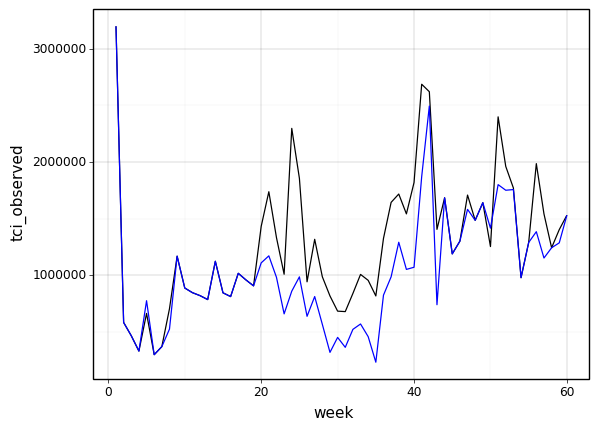

<ggplot: (8729434220233)>

In [34]:
gg = (p9.ggplot(df_union[df_union.region_slug == 'kingston'],
                    p9.aes(x = 'week', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tci_cleaned'), color = 'blue'))
gg

In [35]:
df_union.to_csv("/home/soniame/private/weekly_weekly_index.csv")

In [50]:
#plt.scatter(df.tcp, df.tcp_clean)
#df[['date', 'region_slug', 'tcp_clean']] 

In [72]:
df.region_slug.unique()[:5]

NameError: name 'df' is not defined

In [52]:
(df
 >> group_by('region_slug')
 >> summarize(min_tcp = _.tcp_clean.abs().min(),
              max_tcp = _.tcp_clean.abs().max(), 
              min_baseline = _.expected_2020.abs().min()/1e6,
              max_baseline = _.expected_2020.abs().max()/1e6,
              min_observed = _.observed.abs().min()/1e6,
              max_observed = _.observed.abs().max()/1e6,
              min_cleaned = _.S2_shift.abs().min()/1e6,
              max_cleaned = _.S2_shift.abs().max()/1e6
              )
 >> arrange(_.max_tcp)
).tail(15)

NameError: name 'df' is not defined

#### Step run

In [ ]:
df_cty = _load_data()

In [ ]:
df_run_1 = _run_step(df_run = df_cty[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
df_run_1.head()

In [ ]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
qry = """
select 
    *
from spd_sdv_waze_corona.prod_daily_weekly_index
limit 10
"""
df = pd.read_sql_query(qry, conn)

In [ ]:
df.columns #sort_values('week_number')

In [ ]:
import pandas as pd
metadata = pd.read_csv("http://tiny.cc/idb-traffic-metadata")

In [ ]:
print(len(metadata.region_slug))
print(metadata.region_slug.unique())

metadata.head()

In [ ]:
metadata[metadata.region_slug == 'mexicocity'].region_shapefile_wkt.to_list()